<a href="https://colab.research.google.com/github/davidho27941/ML_tutorial_notebook/blob/main/RL_basic_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 強化學習小遊戲小遊戲 － 拉霸機遊戲

## 前言
假設一遊戲場之中，有10台拉霸機，各自有不同的出貨機率。我們要如何利用機器學習的方法，讓模型學習如何獲得最大利益呢？答案是可以靠著強化學習來達成這一點。

## 安裝必要函式庫

在開始之前，我們需要先導入我們將用到的函式庫。在此範例中，我們將使用下列函式庫來協助我們建立一個利用強化學習解決拉霸機遊戲的模型。

### 數據分析相關
- [Numpy](https://numpy.org/doc/stable/index.html)
- [Matplotlib](https://matplotlib.org/)
- [Scipy](https://scipy.org)

### 機器學習相關
- [PyTorch](https://pytorch.org)
- [PyTorch-Lightning](https://www.pytorchlightning.ai/)

### 其他
- [Time](https://docs.python.org/zh-tw/3/library/time.html)
- [Typing](https://docs.python.org/3/library/typing.html)
- [IPython](https://ipython.org/)



In [1]:
!pip3 install -q torch torchvision torchaudio pytorch-lightning
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pytorch_lightning as pl 
import torch.nn.functional as F

from scipy import stats
from IPython.display import clear_output
from time import sleep
from typing import List

## 用語定義

在本篇教學中，我們將使用以下用語代稱：

- 代理人（Agent）：係指演算法或是模型。
- 回饋（Reward）：係指執行某動作或做出某選擇後，所得到的結果所帶來之利益以及損失。

## 情景建立

首先，假設我在一個遊樂場中。遊樂場內有一組10台(`N_devices = 10`)的拉霸機，每一台的中獎率為$p_{i}$，$i$為拉霸機的編號，範圍從０到９為止。我們可以根據此設定，來定義一個長度為10的串列`Reward_prob`，用以儲存每一台拉霸機的中獎率。

In [2]:
N_devices = 10
Reward_prob = np.random.rand(N_devices)
for idx, prob in enumerate(Reward_prob):
  print(f'機台：{idx}, 中獎機率：{prob:.3f}')

機台：0, 中獎機率：0.711
機台：1, 中獎機率：0.058
機台：2, 中獎機率：0.454
機台：3, 中獎機率：0.461
機台：4, 中獎機率：0.093
機台：5, 中獎機率：0.819
機台：6, 中獎機率：0.522
機台：7, 中獎機率：0.700
機台：8, 中獎機率：0.268
機台：9, 中獎機率：0.033


## 小試身手

假設我們嘗試每一台機器都玩了10次，我們要如何計算每一台拉霸機的期望收益，又如何取得哪一台拉霸機才是最能獲得利益的機台呢？我們可以先思考一個隨機模擬的遊戲。

---
假設在地上有一個圓圈，我們可以隨機的往圓圈丟10次石頭。只有在我們的石頭落在指定的範圍內
時，我們才可以獲得獎勵。那我們如何計算我們在每次玩這個遊戲時，能獲得多少的獎勵，以及玩了一百次時，平均獲得的獎勵數量呢？

首先，我們可以用`throw_ball`函式來隨機產生一個0~1之間的值，並給定一個範圍`prob`用以界定可以獲得獎勵的範圍。然後寫一個函數`play_game`來根據給定的範圍，執行一個丟十次球的遊戲，並在遊戲結束時計算獲得的獎勵。

In [3]:
prob = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
def throw_ball():
    return np.random.random()

def play_game(prob):
    reward = 0
    for _ in range(10):
        if throw_ball() < prob:
            reward += 1
        else: 
            pass
    return reward 

result = play_game(prob)
print(f"玩了一場遊戲： 得到{result}獎勵！")

玩了一場遊戲： 得到7獎勵！


接下來，我們將重複遊玩這個遊戲2000次，來觀察我們在遊玩過程中的獎勵分佈，以及平均收益為何。我們將利用一個串列`rewards`來儲存每一次的獎勵紀錄。

平均收益：1.985


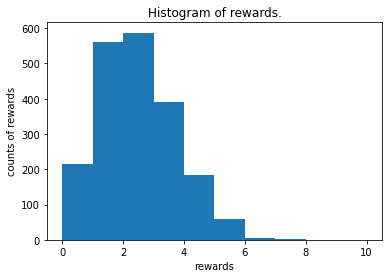

In [4]:
prob = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
rewards = []
for idx in range(2000):
    reward = play_game(prob)
    rewards.append(reward)

plt.figure(figsize=(6,4))
plt.hist(rewards, bins=[x for x in range(0,11,)])
plt.title("Histogram of rewards.")
plt.xlabel("rewards")
plt.ylabel("counts of rewards")
print(f"平均收益：{np.mean(rewards)}")


由上方的小遊戲我們可以看出，當我們改變了可以得到獎勵的範圍時，所能得到的獎勵也隨之增加，反之亦然。那麼我們也可以利用類似的手法來模擬出遊玩每個拉霸機時，所能獲取到的收益，並找出最能夠賺錢的拉霸機。

---
## 前置準備與遊戲流程

### 遊戲流程
在接下來的遊戲中，我們將在每一回合遊玩一台特定的拉霸機特定的拉霸機**10次**，並計算收益。我們總共將進行進行500個回合。

### 前置準備
為了能夠紀錄遊玩每一台拉霸機的收益紀錄，我們可以考慮這麼做：

1. 以一個陣列`record`紀錄每一台拉霸機的遊玩次數（n）以及**平均**收益（$\mu$）。
2. 編寫一個`update_record()`函式用以更新每個機台的收益以及遊玩次數的紀錄。
3. 編寫`get_reward()`以及`get_best_arm()`函式用以取得當次遊玩的收益以及收益最佳的拉霸機。
4. 建立一個`rewards`串列來紀錄每回合收益的平均。

為何在`record`中，我們選擇紀錄平均值而非每次的收益？這是因為如果要紀錄每次的收益，當遊玩次數非常多時，我們所需要的資源將變得將當得多。而紀錄平均值的好處是，我們將能透過更少的資源紀錄到更多的資訊。

In [5]:
# record: A list with length = N_devices and contains [n, \mu] of each device.
record = np.zeros((N_devices, 2))
rewards = [0]
def get_reward(prob: float) -> int:
    reward = 0
    for _ in range(10):
        if np.random.random() < prob:
            reward += 1
    return reward

def update_record(
                  record: List, 
                  device: int, 
                  current_reward: int,
                  ) -> List:
    new_avg = (record[device, 0] * record[device, 1] + current_reward) / (record[device, 0] + 1)
    record[device, 1] = new_avg
    record[device, 0] += 1
    return record

def get_best_arm(record: List) -> int:
    best_arm = np.argmax(record[:, 1],)
    return best_arm

## 貪婪策略

在真正開始玩拉霸機遊戲之前，我們需要再引入一個新概念：[貪婪策略](https://zh.m.wikipedia.org/zh-tw/%E8%B4%AA%E5%BF%83%E7%AE%97%E6%B3%95)。

貪婪策略可以簡述為：在每一步的決策或是行動中，演算法將採取已知最大利益的選擇，進而獲取最大利益的作法。

我們將引入一個介於0到1之間的常數 $\epsilon$，用以表達貪婪程度。當 $\epsilon$ 越高時，我們的代理人將更傾向去遊玩已知最大收益的拉霸機；反之，代理人將開始去尋找其他可能帶來更高收益的拉霸機。

In [6]:
epsilon = 0.7 #@param {type: "slider", min:0, max:1, step: 0.1}


那麼，就讓我們開始玩拉霸機吧！

## 建立遊戲流程

接下來，我們將利用前面幾個章節所建立的函式，來構築我們的遊戲流程。

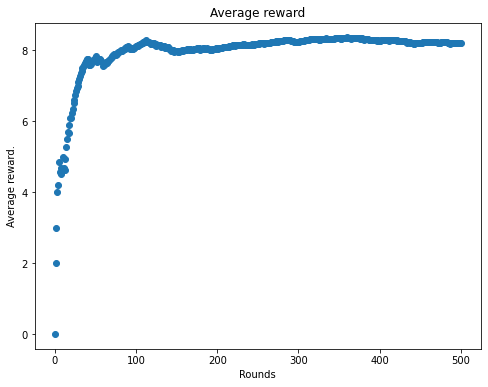

In [7]:
epsilon = 0.7 #@param {type: "slider", min:0, max:1, step: 0.1}
N_devices = 10 #@param {type: "slider", min:1, max:100, step: 1}
N_game = 500 #@param {type: "slider", min:100, max:1000, step: 10}
prob_devices = np.random.rand(N_devices)
record = np.zeros((N_devices, 2))
rewards = [0]
for round_idx in range(N_game):
    # 選擇要遊玩的機台
    if np.random.random() < epsilon:
        choice = get_best_arm(record)
    else: 
        choice = np.random.randint(10)
    reward_in_game = get_reward(prob_devices[choice])
    record = update_record(record, choice, reward_in_game)
    mean_reward = ((round_idx+1) * rewards[-1] + reward_in_game) / (round_idx+2)
    rewards.append(mean_reward)

plt.figure(figsize=(8,6))
plt.scatter(np.arange(len(rewards)),rewards)
plt.title("Average reward")
plt.xlabel("Rounds")
plt.ylabel("Average reward.")
plt.show()

## 其他選擇策略

在先前我們使用了貪婪策略來讓代理人在一定機率下採取探索其他可能性的選擇。除了貪婪策略以外，我們也可以利用`Softmax`函數來產生一個機率分佈，並在此機率分佈下讓代理人隨機選擇一個機台來進行遊戲。

Softmax函數的形式如下：


# $Softmax = \frac{e^{\beta V_{i}}}{∑_{i=0}^{N}e^{\beta V_{i}}}$


其中，$V_{i}$為價值函數（每一個動作的相應價值或收益），$\beta$為溫度常數。$V_{i}$在我們此次的遊戲中等價於`record`陣列中的第二項。

我們可以使用`Softmax`函數取代貪婪策略，讓遊戲在`Softmax`所產生的機率分佈中選擇一個機台進行遊戲。

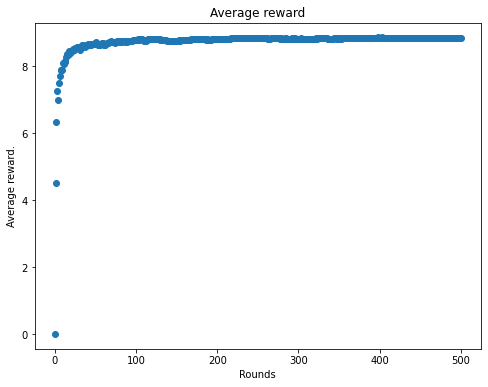

In [8]:
N_devices = 10 #@param {type: "slider", min:1, max:100, step: 1}
N_game = 500 #@param {type: "slider", min:100, max:1000, step: 10}
prob_devices = np.random.rand(N_devices)
record = np.zeros((N_devices, 2))
rewards = [0]

def softmax(v, beta=1/1.12):
    softm = ( np.exp(v * beta) / np.sum( np.exp(v * beta) ) )
    return softm

for round_idx in range(N_game):
    # 選擇要遊玩的機台
    probability = softmax(record[:, 1], beta=1/0.7)
    choice = np.random.choice(np.arange(N_devices), p=probability)
    reward_in_game = get_reward(prob_devices[choice])
    record = update_record(record, choice, reward_in_game)
    mean_reward = ((round_idx+1) * rewards[-1] + reward_in_game) / (round_idx+2)
    rewards.append(mean_reward)

plt.figure(figsize=(8,6))
plt.scatter(np.arange(len(rewards)),rewards)
plt.title("Average reward")
plt.xlabel("Rounds")
plt.ylabel("Average reward.")
plt.show()

## 將深度學習導入強化學習

在先前的範例中，我們都使用一個串列來紀錄每一個機台所能帶來的收益，這是基於傳統的Q-Learning方法所進行的訓練。Q-Learning是一個透過一張表(Q-Table)記錄下過往所有學習過的策略所帶來的回饋以及獎勵，來取得最大化利益的策略。Q-Learning的好處是不需要針對環境進行建模，只需要紀錄過往所有操作所帶來的影響，並從中學習；壞處是當條件以及遊戲越來越複雜時，Q-Table的大小將變得非常巨大，對整體效率以及表現造成拖累。

為了改善為了改善Q-Learning的缺陷，我們可以透過將機器學習導入到Q-Learning，建構出Deep Q-Learning，或稱為Deep Q-Network(DQN)。DQN的做法即為利用神經網路取代傳統的Q-Learning演算法，利用神經網路來取代Q-Table，來利用更小的參數空間對更複雜的狀況作出預測。

### 廣告推薦問題

在前一個拉霸機遊戲的場景中，沒有一個「狀態」的概念，整體上只是一個**動作－回饋值**的組合問題，所需要的表不需要太大的空間即可描述所有組合。當問題出現的「狀態」的考量時，就會形成**狀態－動作－回饋值**的組合問題，此時我們所需要的參數空間就會變得更加巨大。考慮10個狀態、10種動作以及10種回饋的組合，我們將需要元素數量為1000的表來紀錄我們的行為，這將大幅提升運算需求。

考慮一個情景：我們現在有一個廣告推送系統。我們要考量客戶所在的電商網站（共10個，編號，編號0~9），以及客戶給的回饋（是否點擊電商網站的廣告）以及所需要執行的動作（推送哪一個電商的廣告）。

我們可以透過建立下方類別物件來建立此問題的環境。

In [9]:
class AdvertiseMachine():
    def __init__(self, N_sites=10):
        """初始化類別，利用`N_sites`建立`self.n_sites`屬性，
           並利用屬性數量以及狀態數量建立一隨機機率矩陣`self.prob_dist`；
           同時產生一隨機狀態`self.state`作為作為用戶所在的網站使用。

        Arg:
        N_sites(str): 網站的數量。初始值為10。
        """
        self.n_sites = N_sites
        self.init_dist()
        self.update_state()

    def init_dist(self):
        """初始化一隨機機率分佈矩陣。
           矩陣大小為n_sites * n_sites。
        """
        states = self.n_sites
        self.prob_dist = torch.rand(states, self.n_sites)
    
    def update_state(self):
        """產生一隨機整數，並作為客戶所在之網站使用。
        """
        self.state = torch.randint(0, self.n_sites, (1,))
    def calc_reward(self, prob):
        """基於給定的機率，取得回饋值。
        """
        _reward = (torch.rand(self.n_sites) < prob).sum()
        return _reward

    def get_reward(self, site):
        """根據給定的網站，取得該網站在機率矩陣中的值，並利用此值傳入`self.reward()`函式計算回饋值。
        """
        reward = self.calc_reward(self.prob_dist[[self.state, [site]]])
        return reward
    
    def get_state(self):
        """取得當前狀態。
        """
        return self.state

    def choose_site(self, site):
        """選取一個網站，並取得此動作的回饋值。
        """
        reward = self.get_reward(site)
        self.update_state()
        return reward

我們可以檢查一下我們所建構的類別物件使否正常運作。

In [10]:
# 建立一個環境
env = AdvertiseMachine()
# 取得一隨機狀態
current_state = env.get_state()
print(f"現在狀態： {current_state}")
# 選擇一網站，並取得動作的回饋。
reward = env.choose_site(1)
print(f"選取網站1，取得回饋值：{reward}")

現在狀態： tensor([2])
選取網站1，取得回饋值：1


## 建立神經網路

接下來，我們可以建立一個神經網路，用以訓練一個深度強化學習模型作為代理人，並讓代理人學習如何推薦用戶相關廣告。

在這個案例之中，我們有10個狀態，每個狀態都有10種動作，一共有100種可能性。因為我們將會把輸入的資訊進行`one-hot`編碼，故輸入層將會是一個具有10*100個神經元的網路。在輸入層之後，我們可以用一個具有100個神經元的隱藏層來作為網路的第二層。由於我們所能做的動作有10種，故輸出層的神經元數量需要設定為10。

在此，我們將使用`pytorch-lightning`函式庫來協助我們建立模型以及訓練模型。

In [16]:
class AdertiseDataset(torch.utils.data.Dataset):
    def __init__(self, env=AdvertiseMachine()):
        self.env = env
    def __len__(self):
        return 1
    def __getitem__(self, index):
        _cur_state = self.env.get_state().clone().detach()
        _data = torch.nn.functional.one_hot(_cur_state, num_classes=self.env.n_sites)
        return torch.squeeze(_data).type(torch.FloatTensor)
        
class AdvertiseModel(pl.LightningModule):
    def __init__(self, env=AdvertiseMachine()):
        super().__init__()
        D_in = 10
        H = 100
        D_out = 10
        self.env = env
        self.rewards = []
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(D_in, H), #隱藏層
                        torch.nn.ReLU(),
                        torch.nn.Linear(H, D_out), #輸出層
                        torch.nn.ReLU(),
                     )
    
    def forward(self, x):
        return self.model(x)

    def train_dataloader(self):
        dataloader = torch.utils.data.DataLoader(
                                                 dataset=AdertiseDataset(env=self.env),
                                                 batch_size=1,
                                                 )
        return dataloader
    def training_step(self, batch, batch_idx):
        current_state = batch
        y_pred = self(current_state)
        prob_dist = F.softmax(y_pred)

        choice = torch.multinomial(prob_dist, 1, replacement=True).type(torch.LongTensor)
        current_reward = self.env.choose_site(choice).type(torch.FloatTensor)
        one_hot_reward = y_pred.clone().detach()

        one_hot_reward[[0], choice] = current_reward
        self.rewards.append(current_reward)
        loss = F.mse_loss(y_pred, one_hot_reward)
        self.env.update_state()
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [17]:
model = AdvertiseModel()
trainer = pl.Trainer(max_epochs=10000, gpus=1)

trainer.fit(model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 2.1 K 
-------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1895: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
`Trainer.fit` stopped: `max_epochs=10000` reached.


在訓練完成後，我們可以透過計算移動平均值，並將其視覺化，來了解我們的代理人是否學習到了如何取得最佳的推薦邏輯，並取得最大的回饋。

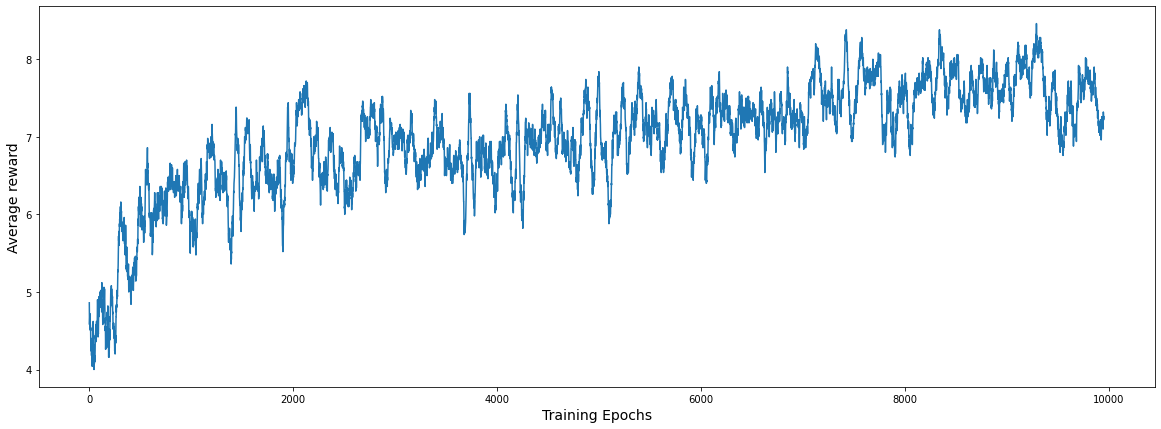

In [13]:
def running_mean(x,N =100): #定義一個可以算出移動平均回饋值的函式
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N #@ is equal to matmul()
    return y

plt.figure(figsize=(20,7))
plt.ylabel("Average reward",fontsize=14)
plt.xlabel("Training Epochs",fontsize=14)
plt.plot(running_mean(np.array(model.rewards),N=50))